## PGD WHITE-BOX ATTACK

In [ ]:
from __future__ import print_function
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset
from drive.MyDrive.small_cnn import *
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
epsilon=0.23
num_steps=10
step_sizes=[.008,.016,.032,.064,.128]
pretrained_model="/content/drive/MyDrive/MNIST_small_cnn.checkpoint"
use_cuda=True

In [13]:
dataset=datasets.MNIST(root='../data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),]))
data=torch.tensor(dataset.data[:10000].float()).unsqueeze(1)
data=(data-data.min())/(data.max()-data.min())
train_ds=TensorDataset(data,dataset.targets[:10000])
test_loader=torch.utils.data.DataLoader(train_ds,batch_size=1,shuffle=True)
device=torch.device("cuda")
model=SmallCNN().to(device)
checkpoint=torch.load(pretrained_model,map_location=torch.device('cuda'))
model.load_state_dict(checkpoint['state_dict'])
model.eval()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


SmallCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (layer_one): Sequential(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU(inplace=True)
  )
  (feature_extractor): Sequential(
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU(inplace=True)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu3): ReLU(inplace=True)
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu4): ReLU(inplace=True)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (fc1): Linear(in_features=1024, out_features=200, bias=True)
    (relu1): ReLU(inplace=True)
    (drop): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=200, out_features=200, bias=True)
    (relu2): ReLU(inplace=True)
    (fc3): Linear(in_features=200, o

In [ ]:
def _pgd_whitebox(model,X,y,epsilon,num_steps,step_size):
    
    X_pgd = Variable(X.data, requires_grad=True)
    
    random_noise = torch.FloatTensor(*X_pgd.shape).uniform_(-epsilon, epsilon).to(device)
    X_pgd = Variable(X_pgd.data + random_noise, requires_grad=True)

    for i in range(num_steps):
        opt = optim.SGD([X_pgd], lr=1e-3)
        opt.zero_grad()

        with torch.enable_grad():
            loss = nn.CrossEntropyLoss()(model(X_pgd), y)
        loss.backward()
        eta = step_size * X_pgd.grad.data.sign()
        X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
        eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
        X_pgd = Variable(X.data + eta, requires_grad=True)
        X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)

    return X_pgd

In [ ]:
def test(model, device, test_loader):
    correct=0
    adv_examples=[]

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad=True
        output = model(data)
        init_pred=output.max(1,keepdim=True)[1]
        if init_pred.item()!=target.item():
            continue
        # pgd attack
        perturbed_x=[]
        X, y = Variable(data, requires_grad=True), Variable(target)
        X_pgd=_pgd_whitebox(model, X, y,epsilon,num_steps,step_size)

        output=model(X_pgd)
        final_pred=output.max(1,keepdim=True)[1]
        if final_pred.item()==y.item():
            correct+=1
        else:
            if len(adv_examples)<5:
                adv_ex=X_pgd.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(),final_pred.item(),adv_ex))
        
    final_acc=correct/float(len(test_loader))
    success_rate=float(len(test_loader)-correct)/float(len(test_loader))
    print("Step Size: {}\tTest Accuracy={}/{}={}\tSuccess Rate={}".format(step_size,correct,len(test_loader),final_acc,success_rate))
    return final_acc,adv_examples

In [ ]:
accuracies=[]
examples=[]

for step_size in step_sizes:
    ac,ex=test(model, device, test_loader)
    accuracies.append(ac)
    examples.append(ex)

Step Size: 0.008	Test Accuracy=8482/10000=0.8482	Success Rate=0.1518
Step Size: 0.016	Test Accuracy=3623/10000=0.3623	Success Rate=0.6377
Step Size: 0.032	Test Accuracy=827/10000=0.0827	Success Rate=0.9173
Step Size: 0.064	Test Accuracy=285/10000=0.0285	Success Rate=0.9715
Step Size: 0.128	Test Accuracy=223/10000=0.0223	Success Rate=0.9777


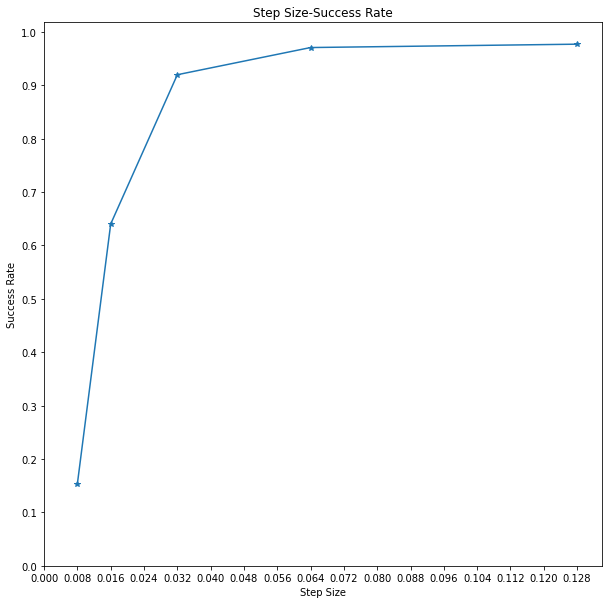

In [23]:
temp=[1,1,1,1,1]
final=[0,0,0,0,0]
for i in range(5):
  final[i]=temp[i]-accuracies[i]

plt.figure(figsize=(10,10))
plt.plot(step_sizes,final,"*-")
plt.yticks(np.arange(0,1.1,step=0.1))
plt.xticks(np.arange(0,.13,step=0.008))
plt.title("Step Size-Success Rate")
plt.xlabel("Step Size")
plt.ylabel("Success Rate")
plt.show()

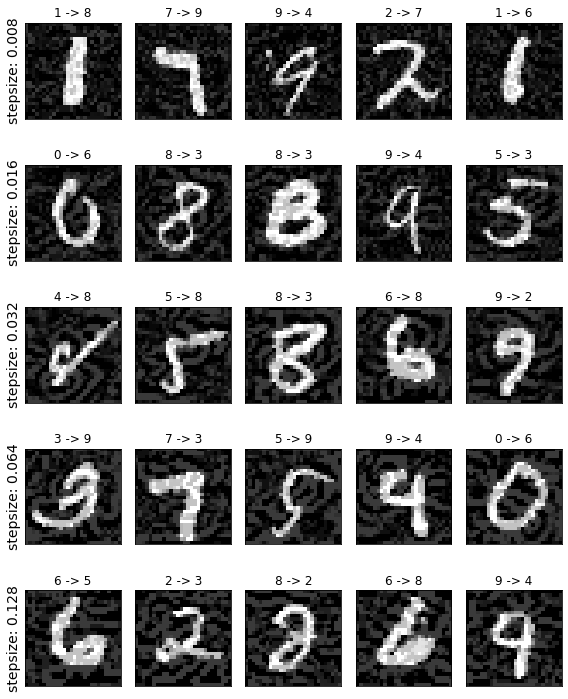

In [ ]:
cnt=0
plt.figure(figsize=(8,10))
for i in range(len(step_sizes)):
  for j in range(len(examples[i])):
    cnt+=1
    plt.subplot(len(step_sizes),len(examples[0]),cnt)
    plt.xticks([],[])
    plt.yticks([],[])
    if j==0:
      plt.ylabel("stepsize: {}".format(step_sizes[i]),fontsize=14)
    orig,adv,ex=examples[i][j]
    plt.title("{} -> {}".format(orig,adv))
    plt.imshow(ex,cmap="gray")
plt.tight_layout()
plt.show()